# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# План выполнения проекта:
1. Проведем исследовательский анализ набора фотографий.


2. Подготовим данные к обучению.


3. Обучим нейронную сеть и рассчитаем её качество.

In [1]:
# Загрузим необходимые для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

SEED = 12345

In [2]:
# Загрузим предоставленный нам датасет и просмотрим его размер
data = pd.read_csv('/datasets/faces/labels.csv')
print(data.shape)

(7591, 2)


In [3]:
# Просмотрим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


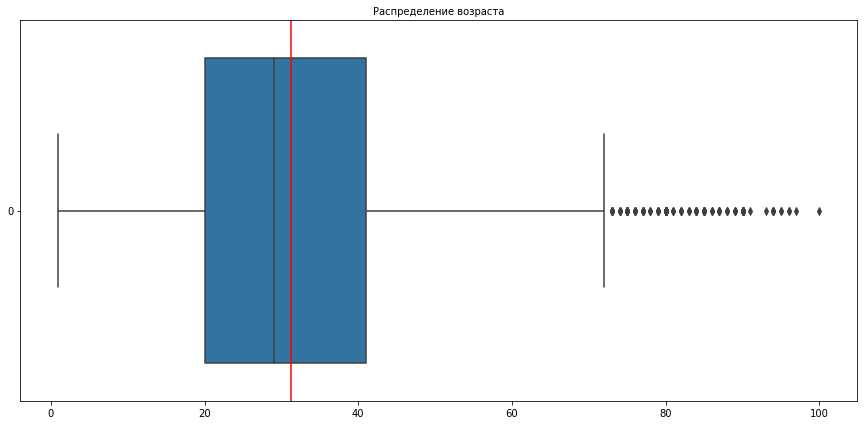

In [4]:
# Построим боксплот и просмотрим распределние возраста
plt.figure(figsize=[15, 7])
plt.title(f'Распределение возраста', fontsize=10)
sns.set_style('darkgrid')
sns.boxplot(data=data['real_age'], orient='h')
plt.axvline(np.mean(data['real_age']), 
            color='r', 
            linestyle='-',
            label='')
median = np.mean(data['real_age'])
mean = np.median(data['real_age'])


Распределение возраста в норме, выбросы после 70

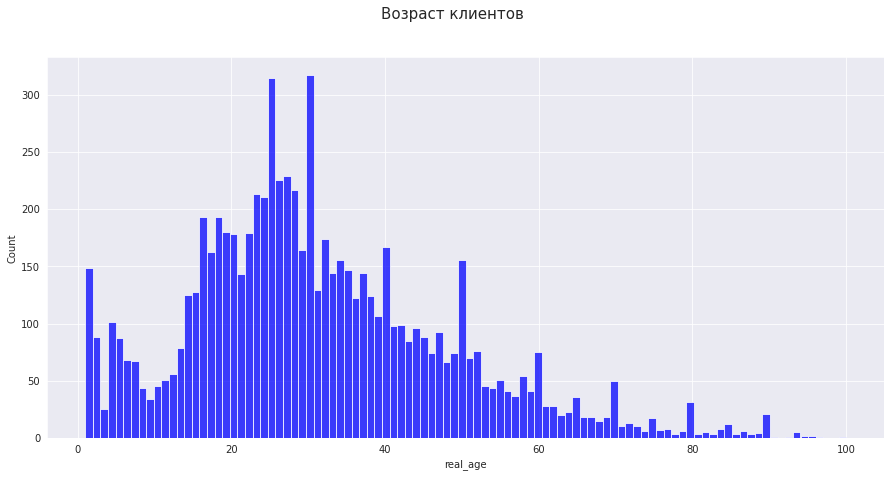

In [5]:
# Построим гистрограмму и просмотрим возраст клиентов
plt.figure(figsize=[15, 7])
plt.suptitle('Возраст клиентов', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=data['real_age'], color='b', label='возраст',bins=100, kde=False)
plt.grid(True)
plt.show();

Наиболее часто встречаются покупатели от 15 до 60 лет.

Напечатаем на экране 15 фотографий из датасета

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                      directory='/datasets/faces/final_files/',
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      seed = SEED)
features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


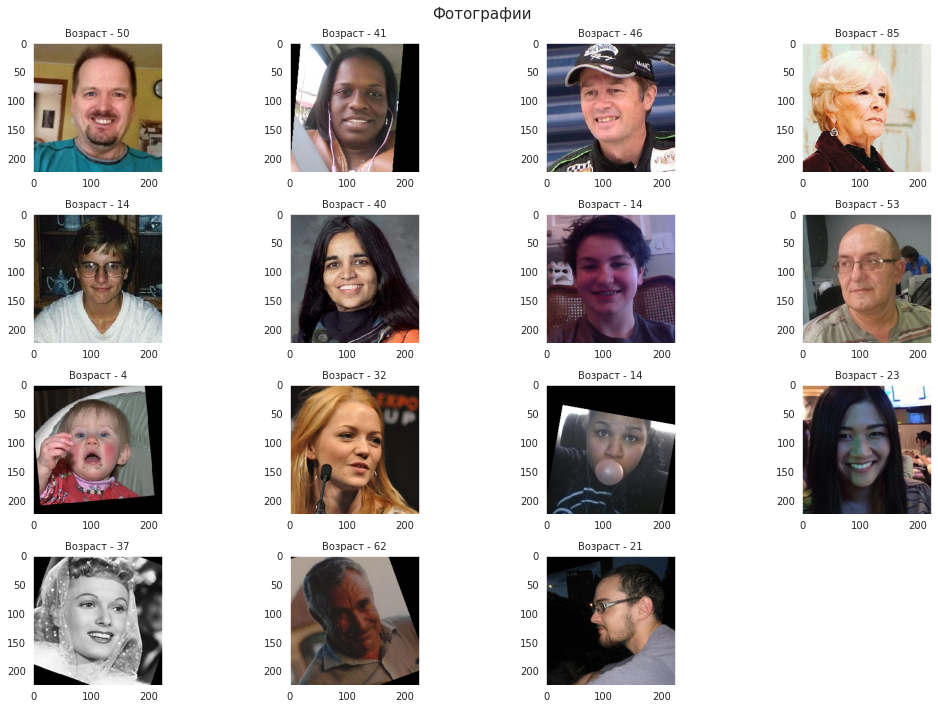

In [8]:
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
for i in range(15):
    plt.suptitle('Фотографии', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст - {target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
plt.tight_layout()

Все фото одного размера, присутствуют и цветные, и черно-белые.
На обучение модели может повлиять разное количество фотографий для возрастов.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = SEED)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = SEED)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-02-22 08:09:46.698769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-22 08:09:47.183332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 124s - loss: 266.3079 - mae: 11.6346 - val_loss: 672.5835 - val_mae: 20.9798
Epoch 2/10
178/178 - 108s - loss: 97.8518 - mae: 7.4331 - val_loss: 525.6865 - val_mae: 17.7565
Epoch 3/10
178/178 - 108s - loss: 73.3055 - mae: 6.4619 - val_loss: 374.0199 - val_mae: 14.7417
Epoch 4/10
178/178 - 108s - loss: 59.8216 - mae: 5.8658 - val_loss: 124.5701 - val_mae: 8.4398
Epoch 5/10
178/178 - 108s - loss: 47.7252 - mae: 5.3153 - val_loss: 77.0963 - val_mae: 6.6111
Epoch 6/10
178/178 - 108s - loss: 43.6038 - mae: 5.0557 - val_loss: 67.9872 - val_mae: 6.2216
Epoch 7/10
178/178 - 108s - loss: 38.2020 - mae: 4.7672 - val_loss: 66.8242 - val_mae: 6.1692
Epoch 8/10
178/178 - 107s - loss: 35.6306 - mae: 4.5998 - val_loss: 134.5602 - val_mae: 9.2775
Epoch 9/10
178/178 - 108s - loss: 29.8493 - mae: 4.2414 - val_loss: 73.3663 - val_mae: 6.5305
Epoch 10/10
178/178 - 107s - loss: 26.3139 - mae: 3.9490 - val_loss: 64.3927 - val_mae: 6.0435
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 64.3927 - mae: 6.0435






```

## Анализ обученной модели

В ходе проекта мы:
1. Провели исследовательский анализ набора фотографий, из которого выяснили:
    - Данные распределены нормально, наблюдаются выбросы после отметки в 70 лет
    - Большая часть фотографий сосредоточена в промежутке между 15 и 60 годами
    - Фотографии одного размера, присутствуют черно-белые и цветные
    
    
2. Подготовили данные к обучению:
    - Написали функцию создания тренировочной выборки, используя:
        - отражение по горизонтали
        - сдвиг по ширине
        - сдвиг по высоте\
        
Аугментации (сдвиги по ширине/высоте и вертикальное/горизонталиное отражения) используются для расширения разнообразия данных, на которых обучается модель. Больше данных - лучше обучение.
        
        
    - Написали функцию создания тестовой выборки
    
    
    - Написали функцию создания модели, используя:
        - нейронную сеть ResNet50
        - алгоритм оптимизации Adam со скоростью обучения lr=0.0001
        
        
    - Написали функцию обучения модели на 10 эпохах


3. Обучили нейронную сеть и рассчитали ее качество, получив показатель MAE: 6.0435

# Вывод:
Модель показала отличный результат по метрике MAE и позволит эффективно решать задачи, поставленные заказчиком.